In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [21]:
dataset = pd.read_csv('../secondMMRintData/5thOrderOuterTime.csv')


In [22]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [23]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 5.81 s, sys: 24 ms, total: 5.83 s
Wall time: 5.83 s


In [24]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
outer = ['EMcrossouter', 'EMfracstdouter', 'EPstdouter', 'MMRstrengthouter','twoMMRstrengthouter']
megno = ['MEGNO', 'MEGNOstd']
#what is being used to train
features = near + far + outer + megno
pfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']
Oldfeatures = near + far + megno

In [233]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [253]:
test1 = filtData.loc[filtData['prelimStable']==True]
data = filtData.loc[filtData['Stable']==False]
#data = filtData

In [254]:
data

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,...,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,...,0.011898,1.283409,0.000000e+00,1.942393,0.032212,True,False,1.235665e+07,8.315223e+07,0
1,1,1,0.190647,0.073477,0.011405,0.048077,0.032956,0.403777,0.005775,0.000461,...,0.010790,0.000314,0.000000e+00,22.918673,7.372319,True,False,1.348749e+05,2.133072e+05,0
2,2,2,0.125660,0.034270,0.001506,0.626885,0.228420,0.720557,0.016427,0.008207,...,0.009609,0.000262,2.923895e-05,11.884854,3.404385,True,False,1.276428e+04,9.321863e+03,0
21,21,21,0.136185,0.015685,0.000632,0.068173,0.044711,0.236705,0.055522,0.011662,...,0.015478,0.101433,1.396545e-03,20.156878,4.424190,True,False,3.590243e+05,6.467315e+05,0
22,22,22,0.031897,0.016720,0.000031,0.025274,0.012913,0.876779,0.000137,0.000002,...,0.000006,0.000003,2.156129e-08,13.420661,2.676203,True,False,2.025613e+06,3.113033e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133537,3537,138537,0.089252,0.175006,0.012456,0.074403,0.022487,0.310694,0.029294,0.000745,...,0.003771,0.004367,4.618388e-04,61.837888,15.143312,True,False,6.303165e+04,6.470086e+04,0
133538,3538,138538,0.082222,0.049940,0.016289,0.608276,0.024447,0.664222,0.031330,0.003745,...,0.000199,0.009017,2.382012e-03,1.998822,0.003453,True,False,6.990387e+05,8.267916e+05,0
133539,3539,138539,0.251338,0.016063,0.002925,0.252494,0.001243,0.272822,0.002159,0.000486,...,0.007186,0.171046,0.000000e+00,2.487767,0.188649,True,False,3.075749e+08,6.576003e+08,0
133540,3540,138540,0.131799,0.027892,0.001453,0.659321,0.032653,0.366664,0.067070,0.020456,...,0.003059,0.074479,8.722457e-05,7.134970,1.931917,True,False,1.193822e+07,3.363291e+07,0


In [255]:
1e9

1000000000.0

(-1.0, 100.0)

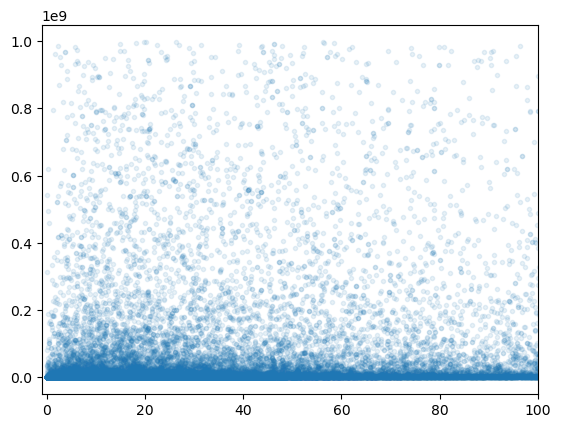

In [258]:
plt.plot((data['EMcrossnear']/data['EMfracstdnear'])*(data['EMcrossfar']/data['EMfracstdfar']), (data['instability_time']), alpha = 0.1, marker = '.', ls = '')
plt.xlim(-1,100)

In [220]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [69]:
scrambled = data.sample(frac=1)